# 기본 함수 및 라이르러리 로드

###### 라이브러리 로드

In [1]:
# 기초 전처리
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
%matplotlib inline

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

## 필요 함수 로드

In [2]:
def get_object_type(df):
    df['상권_코드'] = df['상권_코드'].apply(lambda x : str(x))
    df.astype({'상권_코드':object})
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

In [4]:
# 피밸류 보는 함수
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
def get_summary(X,y):
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_VIF(df):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

## 검정 함수

### vif 관련 함수

In [6]:
def get_vif(X, least=100):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # 피처마다의 VIF 계수를 출력(소수점 4째자리까지만 출력)
    pd.options.display.float_format = '{:.4f}'.format

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    print(vif)
    print('\n')
    return vif[vif['VIF Factor']>least]

In [7]:
def get_corr(df):

    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

### AIC 기반 회귀 함수

In [8]:
def processSubset(X,y,feature_set):

    feature = list(feature_set) 
    model = sm.OLS(y,X[feature]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    data = regr.summary()
    return {"model" : regr, "AIC" : AIC, "SUMMARY":data, "Features":feature}
    

In [9]:
import time
import itertools 

# getBest : 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수

def getBest(X,y,k):
    tic = time.time()      # 시작 시간
    results = []           # 결과 저장 공간
    for combo in itertools.combinations(X.columns.difference(['const']),k):
        # 각 변수 조합을 고려한 경우의수
        
        combo = (list(combo)+['const'])
        # 상수항을 추가하여 combo를 결성
        
        results.append(processSubset(X,y,feature_set = combo)) # 모델링된것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분석하여
        # 저장 후 그 중 AIC가 가장 낮은 모델을 선택하도록 함

    models = pd.DataFrame(results) # 데이터프레임으로 모델결과 변환
    best_model = models.loc[models['AIC'].argmin()] # argmin은 최소값의 인덱스를 뽑는 함수
    toc = time.time()       # 종료 시간
    print("Processed", models.shape[0], "models on", k, "predictors in",(toc - tic),"seconds.")
    
    return best_model

###### 전진선택법

In [10]:
### 전진석택법(step=1)

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
### 전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    return Fmodels
#     return (Fmodels['model'][len(Fmodels['model'])])


###### 후진소거법

In [11]:
### 후진소거법(step=1)

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model","SUMMARY","Features"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[idx] = Backward_result
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
        idx+=1
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels.dropna()
#     return Bmodels["model"].dropna().iloc[0]

#### 단계적 선택법

In [12]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    predictors = []
    Stepmodels.loc[1] = getBest(X,y,k=1)
#     Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    predictors = Stepmodels.loc[1]['model'].model.exog_names
    predictors = [k for k in predictors if k != "const"]
    print(predictors)
    Smodel_before = Stepmodels.loc[1]['AIC']
    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(2,len(X.columns.difference(['const']))+1) :
        print('step:',i-1)

        Forward_result = forward(X=X,y=y,predictors = predictors ) # constant added
        Backward_result = backward(X=X,y=y,predictors = predictors)
        
        
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('backward')
            
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('##forward##')
            
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
            
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Stepmodels
#     return (Stepmodels["model"][len(Stepmodels["model"])])

###### AIC 시각화

In [13]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')
 
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC  = result['AIC'].to_list()
    features = [f'step {i+1}\n'+'\n'.join(s) for i,s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps,AIC, marker='o')
    
    plt.ylabel('AIC',fontsize=font_size)
    plt.grid(True)
    plt.show()
 

### R-square 기반

#### 전진선택법

In [14]:
def forward_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])

    ## 전진 선택법
    variables = df_X.columns.tolist() ## 설명 변수 리스트

    # df_y= df['Survival_Time'] ## 반응 변수
    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = df_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(df_y,X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())

            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit().rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
        
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return df_result


#### 후진선택법

In [15]:
def backward_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])
    ## 후진 소거법
    variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트

    # df_y= df_X['Survival_Time'] ## 반응 변수
    selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(selected_variables) > 0:
        X = sm.add_constant(df_X[selected_variables])
        p_vals = sm.OLS(df_y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
        max_pval = p_vals.max() ## 최대 p-value
        if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
            remove_variable = p_vals.idxmax()
            selected_variables.remove(remove_variable)

            step += 1
            steps.append(step)
            model = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit()
            adj_r_squared = model.rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()
    
    return df_result




#### 단계적 선택법

In [16]:
def stepwise_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])
    ## 전진 단계별 선택법
    variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트

    # df_y= df_X['Survival_Time'] ## 반응 변수
    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = df_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(df_y,X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = df_X[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(df_y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break

            step += 1
            steps.append(step)
            model = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit()
            adj_r_squared = model.rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return df_result

###### 자료 로드

###### base 생성

In [17]:
bs_area = gpd.read_file('data/geojson/상권_geometry_좌표.geojson', driver= 'GeoJSON')
bs_area= bs_area[bs_area['TRDAR_SE_C'] == 'A']
df_base = bs_area[['TRDAR_CD','TRDAR_SE_1']].sort_values('TRDAR_CD').reset_index(drop=True)
df_base.columns = ['상권_코드', '상권_이름']
df_base = get_object_type(df_base)
df_base.head()

,상권_코드
0,1000001
1,1000002
2,1000003
3,1000004
4,1000005


#   4대지표 정리

## 1. 상권이 얼마나 발달했는가?

* 단순지표

1. 총매출

2. 고객수를 대표 할 지수

3. 점포의 수

5. 유동인구

5. 가게 생존률 : 개폐업률

6. 면적

*  복합지표



1. 면적대비 매출

2. 점포수 대비 매출

3. 면적 대비 점포수

1. 재방문율? 고정 방문 고객수? 

In [18]:
df_i1_development = pd.read_csv('data/indicator/상권_발달_지수.csv')
df_i1_development = get_object_type(df_i1_development)
df_i1_development

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00,3.75,2.25,1.433523e+10,0.872042,148.215330,16.627639,29.815076
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75,5.00,5.50,2.084769e+10,0.826819,200.467009,84.359420,15.420539
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00,4.50,3.50,3.196072e+10,0.709322,218.518656,71.899687,59.211507
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00,4.50,3.50,8.668921e+09,1.004444,182.190421,36.836315,24.889402


##  2. 상권의 고객층은 어떠한가?

* 단순지표

1. 업종별 매출 금액 : 
2. 요일별 매출 금액 : 구성(비율) -  실 거래가도 필요!!
3. 소득 수준 : 변형 방식 잘못됨 - 원래 값 가지고 오면,  정규화 하느게 나을거 같음!
4. 성별?! : 매출에 대한 비율, 실 거래가 필요!!
5. 연령?! : 매출에 대한 비율, 실 거래가 필요 !!


* 복합지표

1. 상권의 다양성 : ok!
2. 고객의 유입성 - 매출을 고객수로 나누어야 하는거 아닌가? 
3. 라이프 지수?!

* 부탁 : 총직장 인구수 --> 상권 발달 지수로 편입

In [19]:
df_i2_diversity = pd.read_csv('data/indicator/상권_다양성_지수.csv')
df_i2_diversity = get_object_type(df_i2_diversity)
df_i2_diversity

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,유흥_비율,패션/미용_비율,교육_비율,요식_비율,의료_비율,자동차_비율,기타_비율,유통업_비율,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,남성_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,남성_매출_금액_비율,여성_매출_금액_비율,상권별_소득금액,다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,2.383339e+07,3.140614e+08,1.844958e+08,3.401026e+09,1.098479e+08,2.162874e+07,1.104666e+09,7.539225e+08,0.004030,0.053109,0.031199,0.575131,0.018576,0.003658,0.186805,0.127492,1.793861e+09,1.989043e+09,2.249773e+09,2.002910e+09,2.336899e+09,2.775185e+09,1.978902e+09,5.268174e+09,8.349831e+09,0.062407,0.069197,0.078268,0.069680,0.081299,0.096546,0.068844,0.386854,0.613146,56459184,3.431027,3497.822761,2.760323e+05,54800
1,1000002,3.323505e+07,1.233347e+09,0.000000e+00,2.824262e+08,0.000000e+00,1.649548e+07,2.757601e+08,5.625196e+08,0.013826,0.513086,0.000000,0.117492,0.000000,0.006862,0.114719,0.234014,1.864865e+09,1.861095e+09,2.020037e+09,2.010279e+09,2.507377e+09,3.009626e+09,2.721385e+09,6.232730e+09,9.299999e+09,0.059151,0.059031,0.064072,0.063763,0.079530,0.095461,0.086318,0.401264,0.598736,52528944,3.090867,1097.584441,3.396471e+05,47092
2,1000003,2.687648e+08,6.158692e+08,5.146111e+09,2.088953e+09,3.048000e+06,9.421422e+07,4.283574e+08,7.717781e+08,0.028540,0.065399,0.546465,0.221826,0.000324,0.010005,0.045487,0.081955,4.151880e+09,4.147718e+09,4.099405e+09,3.529069e+09,4.115786e+09,6.076924e+09,2.622511e+09,1.490993e+10,1.083067e+10,0.076204,0.076127,0.075241,0.064773,0.075541,0.111536,0.048134,0.579238,0.420762,46548880,3.492629,4147.017560,1.818920e+05,158024
3,1000004,2.845950e+06,2.521403e+07,5.960735e+07,1.048493e+09,1.619301e+08,1.963030e+07,2.291818e+08,9.595252e+08,0.001135,0.010060,0.023782,0.418322,0.064606,0.007832,0.091438,0.382826,1.677315e+09,1.723738e+09,1.796036e+09,1.495531e+09,1.689890e+09,1.324265e+09,1.015283e+09,5.602198e+09,4.587237e+09,0.080210,0.082430,0.085888,0.071517,0.080812,0.063327,0.048551,0.549805,0.450195,47223072,2.480483,846.936653,1.580492e+06,6784
4,1000005,0.000000e+00,1.305581e+08,8.196169e+07,4.654974e+09,0.000000e+00,1.527319e+09,5.503179e+08,4.557695e+08,0.000000,0.017641,0.011075,0.628974,0.000000,0.206369,0.074358,0.061583,8.446228e+08,1.235422e+09,1.465347e+09,1.186086e+09,1.481575e+09,2.264371e+09,1.957322e+09,4.489870e+09,4.827498e+09,0.042761,0.062546,0.074187,0.060049,0.075008,0.114639,0.099094,0.481882,0.518118,63642816,3.274153,5668.408506,6.135199e+05,17008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,2.512648e+07,1.447867e+08,2.804269e+08,1.181328e+09,2.466564e+07,2.065871e+08,9.684341e+08,1.122737e+09,0.006355,0.036617,0.070921,0.298761,0.006238,0.052246,0.244919,0.283943,1.766752e+09,1.910530e+09,1.910759e+09,2.026241e+09,1.659804e+09,1.935173e+09,1.291661e+09,6.268783e+09,5.806702e+09,0.071888,0.077738,0.077748,0.082447,0.067536,0.078741,0.052557,0.519133,0.480867,48022416,3.577553,541.685637,1.472776e+06,8488
1006,1001007,3.343640e+06,1.694507e+08,7.354804e+07,1.514327e+09,1.984390e+08,5.059799e+09,1.252837e+09,6.572703e+09,0.000225,0.011415,0.004955,0.102013,0.013368,0.340855,0.084398,0.442772,2.363785e+09,2.517307e+09,3.468178e+09,2.780483e+09,2.931596e+09,2.226779e+09,9.491458e+08,1.078403e+10,5.365248e+09,0.070801,0.075399,0.103879,0.083282,0.087808,0.066697,0.028429,0.667772,0.332228,40991088,3.407494,3053.619034,4.460992e+06,3864
1007,1001008,3.649771e+07,3.771270e+08,2.032622e+07,3.218844e+09,0.000000e+00,3.447343e+07,2.286670e+08,3.225350e+08,0.008611,0.088977,0.004796,0.759435,0.000000,0.008133,0.053950,0.076097,2.678396e+09,3.042313e+09,3.040061e+09,3.019629e+09,3.781381e+09,4.055309e+09,3.053337e+09,1.371922e+10,8.391559e+09,0.059811,0.067937,0.067887,0.067431,0.084441,0.090558,0.068183,0.620477,0.379523,44387424,3.228552,780.36

In [20]:
df_i2_diversity.columns = [x.replace('다양성_지수', '고객_다양성_지수') for x in df_i2_diversity.columns]

## 3. 상권의 지리적 특성은 어떠한가?

In [21]:
df_i3_geo = pd.read_csv('data/indicator/상권_지리적_지표.csv')
df_i3_geo = get_object_type(df_i3_geo)
df_i3_geo

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,다양성_지수
0,1000001,4.675446e+06,544.0,2800.0,582.0,245.0,3.917831e-09,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.777462
1,1000002,3.689914e+06,179.0,4372.0,5775.0,2984.0,4.348221e-09,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.796312
2,1000003,1.241185e+07,32.0,982.0,1386.0,0.0,5.626303e-09,29.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,4.0,2.0,0.0,1.082380
3,1000004,4.357117e+06,917.0,4753.0,2021.0,124.0,6.733993e-09,8.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.970116
4,1000005,1.612400e+06,421.0,1210.0,2220.0,1006.0,2.961807e-09,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,4.224173e+06,853.0,6621.0,15482.0,3488.0,4.517399e-09,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.636514
1006,1001007,2.451149e+06,377.0,2274.0,1092.0,0.0,6.468466e-09,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.960892
1007,1001008,4.373616e+06,590.0,3890.0,4402.0,44.0,5.391740e-09,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.636514
1008,1001009,4.373616e+06,765.0,4435.0,8920.0,2724.0,4.930576e-09,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.848686


In [22]:
df_i3_geo.columns = [x.replace('다양성_지수', '지리_다양성_지수') for x in df_i3_geo.columns]

##  4. 문화적 코드는 어떠한가?

* 단순지표

1. 상권별 단순 좋아요 표현

* 범위를 어떻게 나눌까?  빈도수 각상권만의 빈도수로 하기에는 1010 너무 많아 무의미 하고


* 문화적 코드를 제외하고서  클러스터링 할꺼자나: 클러스터링 한 레이블 값: 상권 상호 보안적으로 나가는거지

* 15나눴더니... 문화적 5개로 나눠진다...

 나눈 다른 코드에서 나누어진 클러스터링 값에 따른 빈도수 / 서울 전체 빈도수 
 
 
 
///////////////////////


이제부터 분석인데!!




// 클러스터링 // 

일단 , 리뷰 식당 이니까... 대표성 

상권 쳐먹!!... 안타 까운

-------------------------

의류 / 패션 


숫자...

어떤 의미를 가지는 숫자를
구하는냐?



리뷰 데이터를 어떻게 정형화 해서 각 상권_코드 숫자를 줄것인가?

    레이블 주거나!!
    
    

클러스터링/// 1010 // 주요 클러스터를 10 ~ 20 개 유사도를 판별하는 

결론 : 솔루션

부족한지를 찾아주는게 좋은데

일치도를 사용 해서

클러스터링 

-------------------------

잘 나가는 대표 을 보고 . 

그 수치값  점포당 유동인구수 나 활동인구수 == 

다양성 이 떨어진다거나... 리뷰 숫자가 적거나 문화정 지수 xxxxxxxxxx  

같은 조건 임에도 불구하고 찾을 수가 없다. 


---> 거리를 지정해서, 문화 공연

위드 코로나 행사 마련 

추천 시스템

df_i4_culture = 

1. 다중공성선 평가 : VIF

2. Feature Selection : Stepwise, 



1. 단순 지표로 



2. 경향성을 보는 거면 될꺼 같애 회귀 계수 




# 회귀를 통한 영향력 평가

## 4대지표 1차 가공

### 종속변수 설정

In [23]:
# # 20_3_4~21_1_2 분기 회귀 계수
# df_t_total = pd.read_csv('data/j_result/수정_매출_회귀계수.csv')
# df_t_total = get_object_type(df_t_total)

df_t_total

20_3_4~21_1_2 분기 회귀 계수는 우선 사용 하지 말고,

In [24]:
df_1년매출 = df_i1_development.iloc[:,:2]

In [25]:
# 1년 매출
df_1년매출

,상권_코드,1년_매출
0,1000001,1.512657e+10
1,1000002,1.599466e+10
2,1000003,2.874329e+10
3,1000004,1.072206e+10
4,1000005,1.043475e+10
...,...,...
1005,1001006,1.250092e+10
1006,1001007,1.723727e+10
1007,1001008,2.267043e+10
1008,1001009,8.707442e+09


### 발달지수

In [26]:
df_i1_development.head()

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101


In [27]:
df_i1_development = df_i1_development.drop(['1년_매출', '1년_매출_log'], axis=1)
df_i1_development

,상권_코드,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217
1,1000002,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826
2,1000003,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380
3,1000004,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080
4,1000005,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00,3.75,2.25,1.433523e+10,0.872042,148.215330,16.627639,29.815076
1006,1001007,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75,5.00,5.50,2.084769e+10,0.826819,200.467009,84.359420,15.420539
1007,1001008,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00,4.50,3.50,3.196072e+10,0.709322,218.518656,71.899687,59.211507
1008,1001009,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00,4.50,3.50,8.668921e+09,1.004444,182.190421,36.836315,24.889402


In [28]:
drop_i1_list = get_vif(df_i1_development.iloc[:,1:].dropna(), 200).features.to_list()

             VIF Factor              features
0  200159983438688.7188          배후지_총_생활인구_수
1   33734828669441.9180         배후지_남성_생활인구_수
2   42688148126734.5625         배후지_여성_생활인구_수
3    1415113787076.3538     배후지_연령대_10_생활인구_수
4    1979604231811.2070     배후지_연령대_20_생활인구_수
5    2055030630787.3584     배후지_연령대_30_생활인구_수
6    1738505936062.7275     배후지_연령대_40_생활인구_수
7    1490517831332.2839     배후지_연령대_50_생활인구_수
8    3623169450820.9941  배후지_연령대_60_이상_생활인구_수
9    4031870749660.2471      배후지_시간대_1_생활인구_수
10   2465024426584.8364      배후지_시간대_2_생활인구_수
11    825742505935.1844      배후지_시간대_3_생활인구_수
12    828857941910.4622      배후지_시간대_4_생활인구_수
13   1615930975016.3245      배후지_시간대_5_생활인구_수
14    984608576163.2042      배후지_시간대_6_생활인구_수
15   1018222841367.9620        배후지_월요일_생활인구_수
16   1015582281513.2474        배후지_화요일_생활인구_수
17   1014324240398.7604        배후지_수요일_생활인구_수
18   1012044860083.2576        배후지_목요일_생활인구_수
19   1006503436667.8950        배후지_금요일_생활인구_수
20   1016040525069.4858        배후지

In [29]:
df_i1_development.drop(drop_i1_list[1:], axis=1, inplace=True)

In [30]:
get_vif(df_i1_development.iloc[:,1:].dropna(), 200)

    VIF Factor      features
0       5.7613  배후지_총_생활인구_수
1     118.6840          점포_수
2      59.1564        점포수_외식
3      32.3807     점포수_미용/의류
4      18.1598       폐업_점포_수
5      11.9429       개업_점포_수
6       4.2568        면적당_매출
7       7.2456            면적
8      97.3160       면적당_점포수
9      54.6071    면적당_외식_점포수
10     27.2931  면적당_미용의류_점포수




,VIF Factor,features


In [31]:
df_i1_development

,상권_코드,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132
1,1000002,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128
2,1000003,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684
3,1000004,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801
4,1000005,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,16.6276,29.8151
1006,1001007,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,84.3594,15.4205
1007,1001008,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,218.5187,71.8997,59.2115
1008,1001009,8715362.5000,183.0000,37.0000,25.0000,4.5000,3.5000,8668920502.1065,1.0044,182.1904,36.8363,24.8894


In [32]:
df_i1_development.columns

Index(['상권_코드', '배후지_총_생활인구_수', '점포_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적당_매출', '면적', '면적당_점포수', '면적당_외식_점포수', '면적당_미용의류_점포수'], dtype='object')

In [33]:
df_i1_selected = df_i1_development.loc[:,['상권_코드','배후지_총_생활인구_수','점포_수', '점포수_외식',
                                          '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', 
                                          '면적당_매출', '면적', '면적당_점포수', '면적당_외식_점포수', 
                                          '면적당_미용의류_점포수']]

### 고객층 지수

In [34]:
df_i2_diversity.head()

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,유흥_비율,패션/미용_비율,교육_비율,요식_비율,의료_비율,자동차_비율,기타_비율,유통업_비율,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,남성_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,남성_매출_금액_비율,여성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0040,0.0531,0.0312,0.5751,0.0186,0.0037,0.1868,0.1275,1793861161.0000,1989042991.0000,2249772956.0000,2002909995.0000,2336898913.0000,2775184673.0000,1978901695.0000,5268173769.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0813,0.0965,0.0688,0.3869,0.6131,56459184,3.4310,3497.8228,276032.3428,54800
1,1000002,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.0138,0.5131,0.0000,0.1175,0.0000,0.0069,0.1147,0.2340,1864864769.0000,1861094638.0000,2020036571.0000,2010278779.0000,2507376995.0000,3009625655.0000,2721384911.0000,6232730450.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0795,0.0955,0.0863,0.4013,0.5987,52528944,3.0909,1097.5844,339647.1230,47092
2,1000003,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0285,0.0654,0.5465,0.2218,0.0003,0.0100,0.0455,0.0820,4151879559.0000,4147717779.0000,4099405321.0000,3529069235.0000,4115786475.0000,6076924031.0000,2622511482.0000,14909928333.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.0755,0.1115,0.0481,0.5792,0.4208,46548880,3.4926,4147.0176,181891.9524,158024
3,1000004,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0011,0.0101,0.0238,0.4183,0.0646,0.0078,0.0914,0.3828,1677314729.0000,1723737702.0000,1796036263.0000,1495531104.0000,1689889584.0000,1324265292.0000,1015283286.0000,5602198454.0000,4587237098.0000,0.0802,0.0824,0.0859,0.0715,0.0808,0.0633,0.0486,0.5498,0.4502,47223072,2.4805,846.9367,1580492.0342,6784
4,1000005,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0000,0.0176,0.0111,0.6290,0.0000,0.2064,0.0744,0.0616,844622792.0000,1235421926.0000,1465347323.0000,1186086496.0000,1481575285.0000,2264370920.0000,1957321740.0000,4489870369.0000,4827497792.0000,0.0428,0.0625,0.0742,0.0600,0.0750,0.1146,0.0991,0.4819,0.5181,63642816,3.2742,5668.4085,613519.9013,17008


In [35]:
drop_i2_list = get_vif(df_i2_diversity.iloc[:,1:].dropna(), 200).features.to_list()

        VIF Factor      features
0           3.5881      유흥_총_매출액
1           2.1504   패션/미용_총_매출액
2           2.7407      교육_총_매출액
3           2.9015      요식_총_매출액
4           2.0185      의료_총_매출액
5           4.0943     자동차_총_매출액
6           1.7355      기타_총_매출액
7           1.8976     유통업_총_매출액
8     5555796.5010         유흥_비율
9    25369182.8866      패션/미용_비율
10  796108343.5330         교육_비율
11 4281256834.9065         요식_비율
12  787882195.0821         의료_비율
13   57887069.5669        자동차_비율
14  304756661.8999         기타_비율
15  885911036.5865        유통업_비율
16         49.7407     월요일_매출_금액
17         64.4579     화요일_매출_금액
18         59.2854     수요일_매출_금액
19         58.9157     목요일_매출_금액
20         44.9440     금요일_매출_금액
21         44.6382     토요일_매출_금액
22         20.8419     일요일_매출_금액
23         57.1840      남성_매출_금액
24         54.0892      여성_매출_금액
25          4.5479  월요일_매출_금액_비율
26          4.3813  화요일_매출_금액_비율
27          3.6735  수요일_매출_금액_비율
28          3.1459  목요일_매출_금액_비율
29        

In [36]:
drop_i2_list

['유흥_비율',
 '패션/미용_비율',
 '교육_비율',
 '요식_비율',
 '의료_비율',
 '자동차_비율',
 '기타_비율',
 '유통업_비율',
 '남성_매출_금액_비율',
 '여성_매출_금액_비율']

In [37]:
drop_i2_list.remove('요식_비율')
drop_i2_list.remove('남성_매출_금액_비율')

In [38]:
df_i2_diversity.drop(drop_i2_list, axis=1, inplace=True)

In [39]:
get_vif(df_i2_diversity.iloc[:,1:].dropna(), 200)

    VIF Factor      features
0       1.0270      유흥_총_매출액
1       1.2940   패션/미용_총_매출액
2       1.4241      교육_총_매출액
3       2.8488      요식_총_매출액
4       1.1971      의료_총_매출액
5       1.2905     자동차_총_매출액
6       1.2359      기타_총_매출액
7       1.3844     유통업_총_매출액
8       2.2787         요식_비율
9      43.8629     월요일_매출_금액
10     57.8951     화요일_매출_금액
11     58.3215     수요일_매출_금액
12     56.9289     목요일_매출_금액
13     44.4850     금요일_매출_금액
14     38.0736     토요일_매출_금액
15     19.1934     일요일_매출_금액
16     77.2704      남성_매출_금액
17     52.5096      여성_매출_금액
18     74.0853  월요일_매출_금액_비율
19     82.3394  화요일_매출_금액_비율
20      2.8987  수요일_매출_금액_비율
21      2.3936  목요일_매출_금액_비율
22      2.6870  금요일_매출_금액_비율
23     81.5682  토요일_매출_금액_비율
24     37.7733  일요일_매출_금액_비율
25      2.0136   남성_매출_금액_비율
26      1.5934      상권별_소득금액
27      1.1856     고객_다양성_지수
28      3.0421  생활인구_당_매출_금액
29      1.8195  직장인구_당_매출_금액
30      1.9095     총_직장_인구_수




,VIF Factor,features


In [40]:
df_i2_diversity.columns

Index(['상권_코드', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '요식_비율', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '남성_매출_금액', '여성_매출_금액', '월요일_매출_금액_비율', '화요일_매출_금액_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', '토요일_매출_금액_비율', '일요일_매출_금액_비율', '남성_매출_금액_비율', '상권별_소득금액', '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수'], dtype='object')

In [41]:
df_i2_selected = df_i2_diversity.loc[:,['상권_코드','유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', 
                                        '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', 
                                        '유통업_총_매출액', '요식_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율',
                                        '금요일_매출_금액_비율',  '남성_매출_금액_비율', '상권별_소득금액',
                                        '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수']]  

In [42]:
df_i2_selected

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800
1,1000002,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092
2,1000003,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024
3,1000004,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784
4,1000005,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488
1006,1001007,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864
1007,1001008,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.7594,0.0679,0.0674,0.0844,0.6205,44387424,3.2286,780.3650,2264325.4972,10012
1008,1001009,6755630.0000,40453627.0000,312999826.0000,600954277.0000,1215332501.0000,1668780986.0000,1614403335.0000,789629898.0000,0.0962,0.0812,0.0697,0.0870,0.5664,50351072,3.7205,249.7728,358980.9368,24256


### 지리 지수

In [43]:
df_i3_geo.head()

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931


In [44]:
drop_i3_list = get_vif(df_i3_geo.iloc[:,1:].dropna(), 200).features.to_list()

    VIF Factor           features
0       4.7877               공시지가
1      13.0130           아파트_단지_수
2      12.3612  아파트_가격_2억_미만_세대_수
3       2.9053   아파트_가격_2~4억_세대_수
4       1.9099   아파트_가격_5억_이상_세대수
5      13.2115          아파트_평균_시가
6      12.9706             집객시설_수
7       1.9656              관공서_수
8       1.7036               은행_수
9       4.7453               약국_수
10      1.2660              유치원_수
11      1.1062              대학교_수
12      1.1774            숙박_시설_수
13      1.1815            지하철_역_수
14      4.2392           버스_정거장_수
15      1.1574         초/중/고등학교_수
16      1.1379               병원_수
17     12.0431          지리_다양성_지수




In [45]:
df_i3_geo.columns

Index(['상권_코드', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [46]:
df_i3_selected = df_i3_geo.loc[:, ['상권_코드', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수',
                                   '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수',
                                   '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', 
                                   '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', 
                                   '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수']]


In [47]:
df_i3_selected

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,4373616.1945,590.0000,3890.0000,4402.0000,44.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.6365
1008,1001009,4373616.1945,765.0000,4435.0000,8920.0000,2724.0000,0.0000,6.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.8487


### 문화 지수

### df_X 통합

In [48]:
# df_X = pd.merge(left=df_base, right=df_i1_selected, how= 'left', on = '상권_코드')
df_X = pd.merge(left= df_i1_selected, right=df_i2_selected, how = 'left', on= '상권_코드')
df_X = pd.merge(left= df_X, right=df_i3_selected, how = 'left', on= '상권_코드')
# df_X = pd.merge(left= df_X, right=df_i4_selected, how = 'left', on= '상권_코드')

In [49]:
df_X.head()

,상권_코드,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931


In [50]:
df_all = pd.merge(left= df_1년매출, right=df_X, how = 'left', on= '상권_코드')

In [51]:
df_all

,상권_코드,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,

In [52]:
df_all.dropna(axis=0, inplace=True)

In [53]:
df_all

,상권_코드,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,

In [54]:
df_all.isnull().sum().sum()

0

### 4대지표 간 vif

In [55]:
vif = get_vif(df_all.iloc[:,2:], 100)

    VIF Factor           features
0      12.9424       배후지_총_생활인구_수
1     147.0674               점포_수
2      72.0519             점포수_외식
3      35.5134          점포수_미용/의류
4      19.4354            폐업_점포_수
5      13.6775            개업_점포_수
6      12.2037             면적당_매출
7      21.6047                 면적
8     125.5266            면적당_점포수
9      62.1657         면적당_외식_점포수
10     28.5117       면적당_미용의류_점포수
11      1.0393           유흥_총_매출액
12      1.3652        패션/미용_총_매출액
13      1.6899           교육_총_매출액
14      6.1461           요식_총_매출액
15      1.3367           의료_총_매출액
16      1.6452          자동차_총_매출액
17      1.4764           기타_총_매출액
18      2.1633          유통업_총_매출액
19     11.9404              요식_비율
20     43.7702       수요일_매출_금액_비율
21     37.2822       목요일_매출_금액_비율
22     51.7553       금요일_매출_금액_비율
23     50.4439        남성_매출_금액_비율
24     93.5586           상권별_소득금액
25    154.0512          고객_다양성_지수
26      8.0464       생활인구_당_매출_금액
27      3.5181       직장인구_당_매출_금액
28      3.4839

In [56]:
vif

,VIF Factor,features
1,147.0674,점포_수
8,125.5266,면적당_점포수
25,154.0512,고객_다양성_지수


In [57]:
drop_features_by_vif = vif.features.to_list()

In [58]:
drop_features_by_vif.remove('고객_다양성_지수')


In [59]:
drop_features_by_vif

['점포_수', '면적당_점포수']

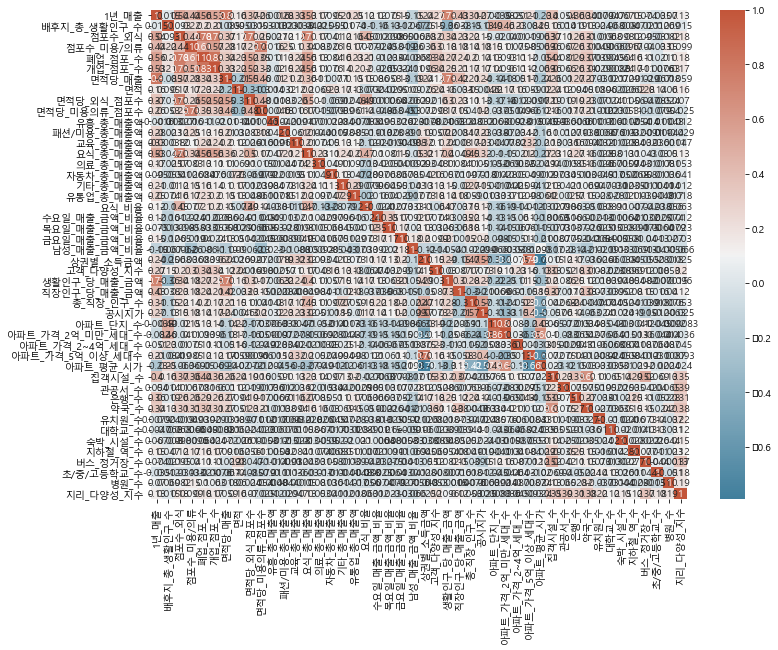

In [60]:
get_corr(df_all.drop(drop_features_by_vif,axis=1).iloc[:,1:])

##  영향력 평가

### 자료 설정

In [61]:
df_ready = df_all.drop(drop_features_by_vif, axis=1)

In [62]:
df_ready

,상권_코드,1년_매출,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,22670426878.0000,7262764.2500,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,71.8997,59.2115,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.7594,0.0679,0.0674

In [63]:
df_ready.columns

Index(['상권_코드', '1년_매출', '배후지_총_생활인구_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적당_매출', '면적', '면적당_외식_점포수', '면적당_미용의류_점포수', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '요식_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', '남성_매출_금액_비율', '상권별_소득금액', '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [64]:
df_y = df_ready.iloc[:,1]
df_y

0      15126572384.0000
1      15994662318.0000
2      28743293882.0000
3      10722057960.0000
4      10434746482.0000
             ...       
1005   12500919837.0000
1006   17237273313.0000
1007   22670426878.0000
1008    8707441604.0000
1009   12326622031.0000
Name: 1년_매출, Length: 989, dtype: float64

In [65]:
df_X = df_ready.iloc[:,2:]

In [66]:
df_X = sm.add_constant(df_X ,has_constant = "add")
df_X

,const,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1.0000,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1.0000,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1.0000,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1.0000,3164952.7500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1.0000,460215.0000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1.0000,5769453.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1.0000,1411216.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1.0000,7262764.2500,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,71.8997,59.2115,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.7594,0.0679,0.0674,0.0844,0.6205,44387424,3.2286,780.3650,2264325.4972,10012,4373616.1945,590.0000,3890.0000,4402.0000,44.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0

### AIC 모델

In [67]:
s_AIC_model = Stepwise_model(df_X, df_y)

Processed 45 models on 1 predictors in 0.1241140365600586 seconds.
['면적당_매출']
step: 1
Processed  44 models on 2 predictors in 0.12311005592346191
Selected predictors: ['면적당_매출', '면적', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C10C4F190>
Processed  1 models on 0 predictors in 0.0030028820037841797
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12134E80>
##forward##
step: 2
Processed  43 models on 3 predictors in 0.1311192512512207
Selected predictors: ['면적당_매출', '면적', '폐업_점포_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12306430>
Processed  2 models on 1 predictors in 0.005003929138183594
Selected predictors: ['면적당_매출', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C1214C220>
##forward##
step: 3
Processed  42 models on 4 predictors in 0.13312172889709473
Selec

Processed  16 models on 15 predictors in 0.046041250228881836
Selected predictors: ['면적당_매출', '면적', '면적당_외식_점포수', '점포수_외식', '교육_총_매출액', '패션/미용_총_매출액', '직장인구_당_매출_금액', '총_직장_인구_수', '은행_수', '생활인구_당_매출_금액', '아파트_단지_수', '점포수_미용/의류', '면적당_미용의류_점포수', '아파트_가격_2억_미만_세대_수', '지리_다양성_지수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C11CF58E0>
##forward##
step: 17
Processed  28 models on 18 predictors in 0.09008312225341797
Selected predictors: ['면적당_매출', '면적', '폐업_점포_수', '면적당_외식_점포수', '점포수_외식', '교육_총_매출액', '패션/미용_총_매출액', '직장인구_당_매출_금액', '총_직장_인구_수', '은행_수', '생활인구_당_매출_금액', '아파트_단지_수', '점포수_미용/의류', '면적당_미용의류_점포수', '아파트_가격_2억_미만_세대_수', '지리_다양성_지수', '자동차_총_매출액', '요식_비율', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12050880>
Processed  17 models on 16 predictors in 0.1211085319519043
Selected predictors: ['면적당_매출', '면적', '면적당_외식_점포수', '점포수_외식', '교육_총_매출액', '패션/미용_총_매출액', '직장인구_당_매출_금액', '총_직장_인구_수

Processed  21 models on 25 predictors in 0.08607816696166992
Selected predictors: ['면적당_매출', '면적', '면적당_외식_점포수', '점포수_외식', '교육_총_매출액', '패션/미용_총_매출액', '직장인구_당_매출_금액', '총_직장_인구_수', '은행_수', '생활인구_당_매출_금액', '아파트_단지_수', '점포수_미용/의류', '면적당_미용의류_점포수', '아파트_가격_2억_미만_세대_수', '지리_다양성_지수', '자동차_총_매출액', '요식_비율', '유통업_총_매출액', '아파트_가격_2~4억_세대_수', '목요일_매출_금액_비율', '개업_점포_수', '상권별_소득금액', '아파트_가격_5억_이상_세대수', '의료_총_매출액', '공시지가', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C11C36940>
Processed  24 models on 23 predictors in 0.07907295227050781
Selected predictors: ['면적당_매출', '면적', '면적당_외식_점포수', '점포수_외식', '교육_총_매출액', '패션/미용_총_매출액', '직장인구_당_매출_금액', '총_직장_인구_수', '은행_수', '생활인구_당_매출_금액', '아파트_단지_수', '점포수_미용/의류', '면적당_미용의류_점포수', '아파트_가격_2억_미만_세대_수', '지리_다양성_지수', '자동차_총_매출액', '요식_비율', '유통업_총_매출액', '아파트_가격_2~4억_세대_수', '목요일_매출_금액_비율', '개업_점포_수', '상권별_소득금액', '아파트_가격_5억_이상_세대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x

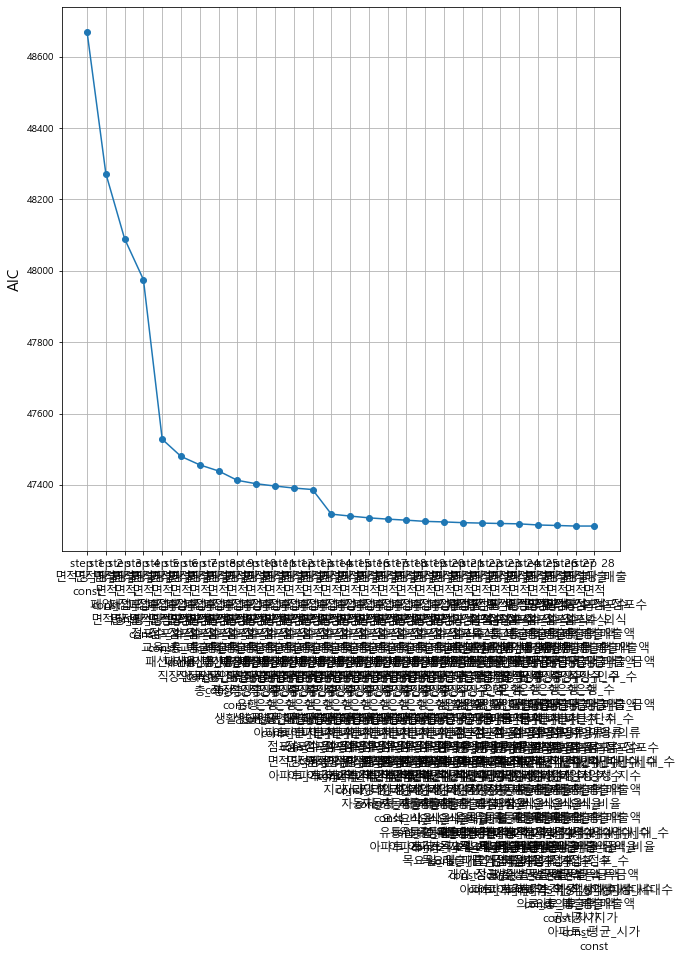

In [68]:
vis_AIC_step(s_AIC_model)

In [69]:
b_AIC_model = backward_model(df_X, df_y)

Processed  45 models on 44 predictors in 0.22471094131469727
Selected predictors: ['개업_점포_수', '고객_다양성_지수', '공시지가', '관공서_수', '교육_총_매출액', '금요일_매출_금액_비율', '기타_총_매출액', '남성_매출_금액_비율', '대학교_수', '면적', '면적당_매출', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '배후지_총_생활인구_수', '버스_정거장_수', '병원_수', '상권별_소득금액', '생활인구_당_매출_금액', '수요일_매출_금액_비율', '숙박_시설_수', '아파트_가격_2~4억_세대_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_5억_이상_세대수', '아파트_단지_수', '아파트_평균_시가', '약국_수', '요식_비율', '요식_총_매출액', '유치원_수', '유통업_총_매출액', '유흥_총_매출액', '은행_수', '의료_총_매출액', '자동차_총_매출액', '점포수_미용/의류', '점포수_외식', '지리_다양성_지수', '직장인구_당_매출_금액', '집객시설_수', '초/중/고등학교_수', '총_직장_인구_수', '패션/미용_총_매출액', '폐업_점포_수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C1252F220>
Processed  44 models on 43 predictors in 0.2722477912902832
Selected predictors: ['개업_점포_수', '공시지가', '관공서_수', '교육_총_매출액', '금요일_매출_금액_비율', '기타_총_매출액', '남성_매출_금액_비율', '대학교_수', '면적', '면적당_매출', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '배후지_총_생활인구_수', '버스

Processed  31 models on 30 predictors in 0.13412117958068848
Selected predictors: ['개업_점포_수', '공시지가', '관공서_수', '교육_총_매출액', '기타_총_매출액', '면적', '면적당_매출', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '상권별_소득금액', '생활인구_당_매출_금액', '수요일_매출_금액_비율', '아파트_가격_2~4억_세대_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_5억_이상_세대수', '아파트_단지_수', '아파트_평균_시가', '요식_비율', '요식_총_매출액', '유통업_총_매출액', '은행_수', '의료_총_매출액', '자동차_총_매출액', '점포수_미용/의류', '점포수_외식', '지리_다양성_지수', '직장인구_당_매출_금액', '총_직장_인구_수', '패션/미용_총_매출액', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12557370>
Processed  30 models on 29 predictors in 0.1981794834136963
Selected predictors: ['개업_점포_수', '공시지가', '관공서_수', '교육_총_매출액', '면적', '면적당_매출', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '상권별_소득금액', '생활인구_당_매출_금액', '수요일_매출_금액_비율', '아파트_가격_2~4억_세대_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_5억_이상_세대수', '아파트_단지_수', '아파트_평균_시가', '요식_비율', '요식_총_매출액', '유통업_총_매출액', '은행_수', '의료_총_매출액', '자동차_총_매출액', '점포수_미용/의류', '점포수_외식', '지리_다양성_지수', '직

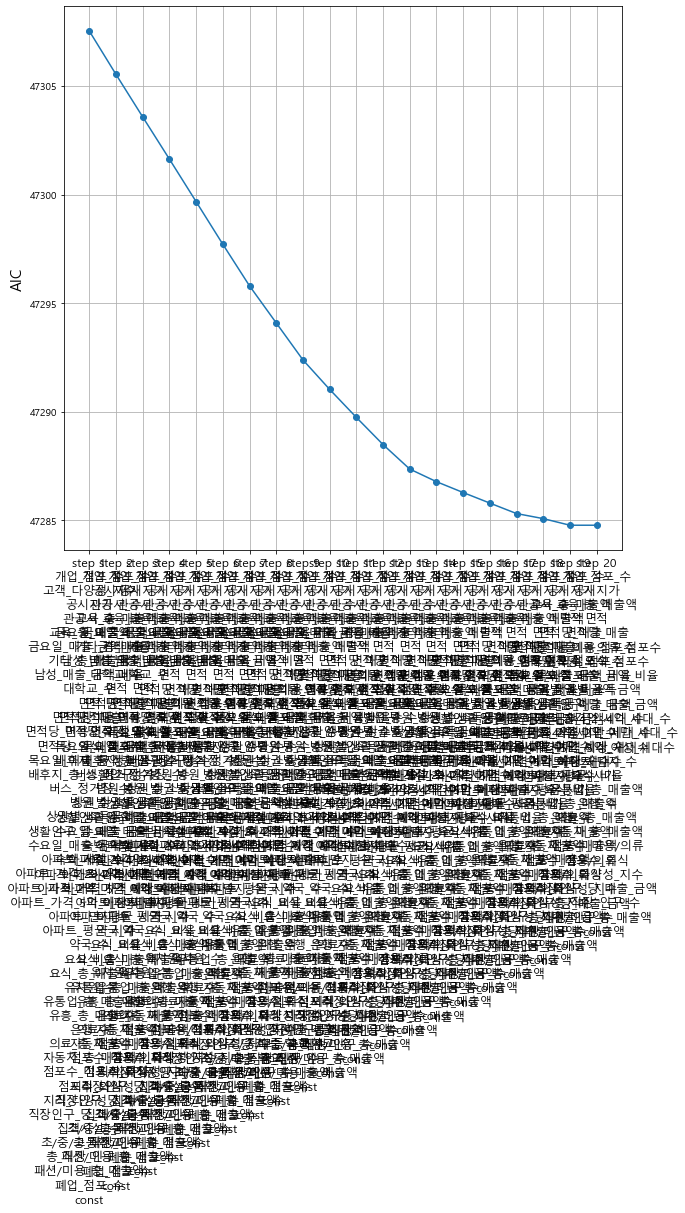

In [70]:
vis_AIC_step(b_AIC_model)

Processed  45 models on 1 predictors in 0.1211087703704834
Selected predictors: ['면적당_매출', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12623D90>
Processed  44 models on 2 predictors in 0.11810684204101562
Selected predictors: ['면적당_매출', '면적', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C10E95F40>
Processed  43 models on 3 predictors in 0.11610555648803711
Selected predictors: ['면적당_매출', '면적', '폐업_점포_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C1120ED00>
Processed  42 models on 4 predictors in 0.19417619705200195
Selected predictors: ['면적당_매출', '면적', '폐업_점포_수', '면적당_외식_점포수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12252FA0>
Processed  41 models on 5 predictors in 0.12010955810546875
Selected predictors: ['면적당_매출', '면적', '폐업_점포_수', '면적당_외식_점포수', '점포수_외식', 'const'] AIC:  <st

Processed  19 models on 27 predictors in 0.07507014274597168
Selected predictors: ['면적당_매출', '면적', '폐업_점포_수', '면적당_외식_점포수', '점포수_외식', '교육_총_매출액', '패션/미용_총_매출액', '직장인구_당_매출_금액', '총_직장_인구_수', '은행_수', '생활인구_당_매출_금액', '아파트_단지_수', '점포수_미용/의류', '면적당_미용의류_점포수', '아파트_가격_2억_미만_세대_수', '지리_다양성_지수', '자동차_총_매출액', '요식_비율', '유통업_총_매출액', '아파트_가격_2~4억_세대_수', '목요일_매출_금액_비율', '개업_점포_수', '상권별_소득금액', '아파트_가격_5억_이상_세대수', '의료_총_매출액', '공시지가', '아파트_평균_시가', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000016C12121D00>
Total elapsed time: 3.484480381011963 seconds.


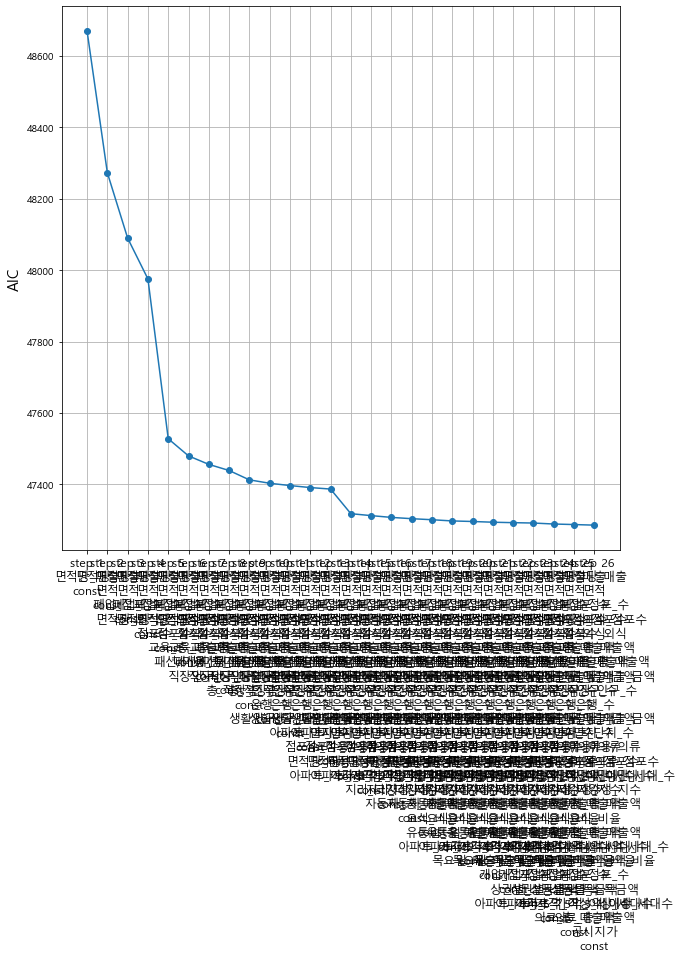

In [71]:
f_AIC_model = forward_model(df_X, df_y)
vis_AIC_step(f_AIC_model)

### R_square 모델

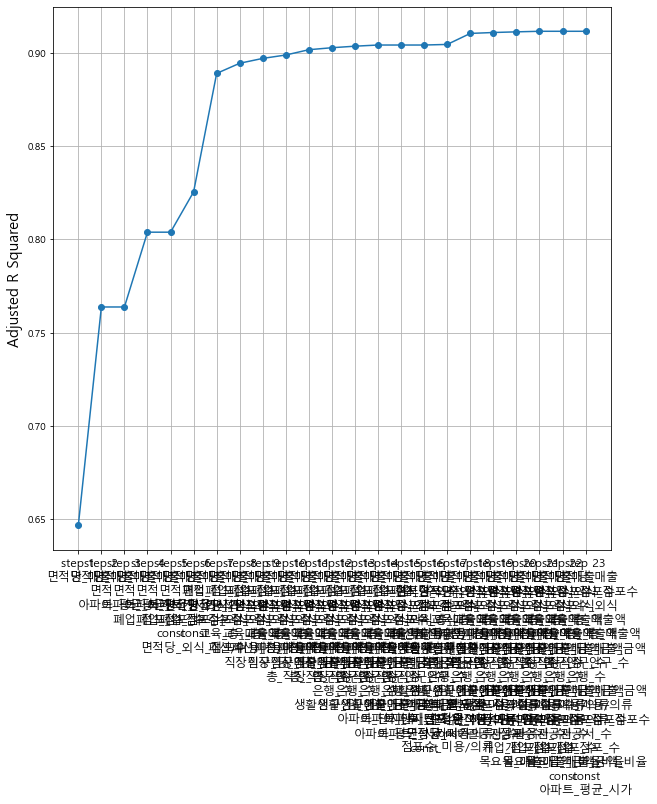

In [72]:
s_R_model = stepwise_R_sq(df_X, df_y)

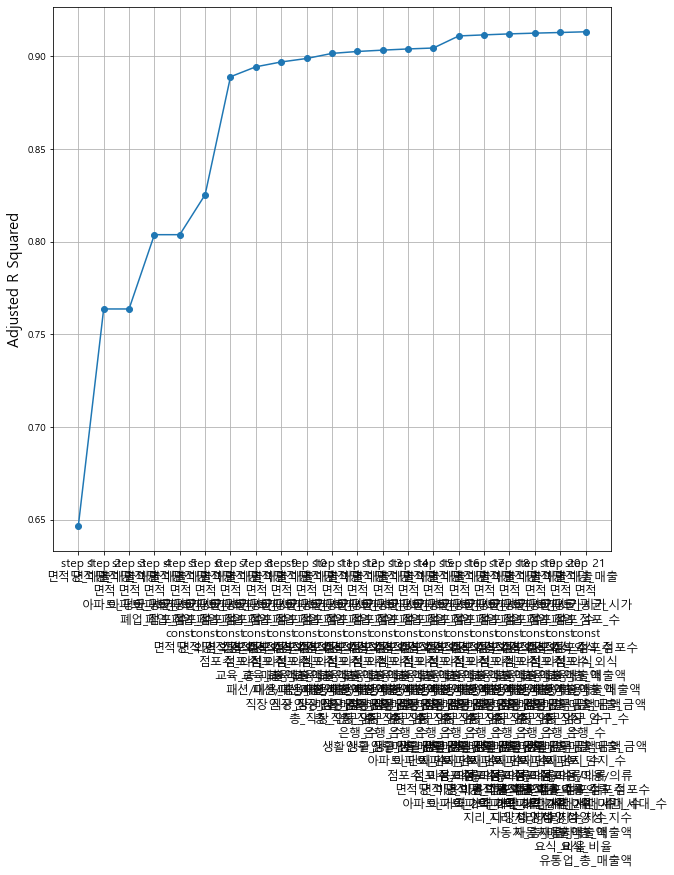

In [73]:
f_R_model = forward_R_sq(df_X, df_y)

In [74]:
f_R_model.sort_values('R_square', ascending=False).head().Features.to_frame()

,Features
21,"[면적당_매출, 면적, 아파트_평균_시가, 폐업_점포_수, const, 면적당_외식..."
20,"[면적당_매출, 면적, 아파트_평균_시가, 폐업_점포_수, const, 면적당_외식..."
19,"[면적당_매출, 면적, 아파트_평균_시가, 폐업_점포_수, const, 면적당_외식..."
18,"[면적당_매출, 면적, 아파트_평균_시가, 폐업_점포_수, const, 면적당_외식..."
17,"[면적당_매출, 면적, 아파트_평균_시가, 폐업_점포_수, const, 면적당_외식..."


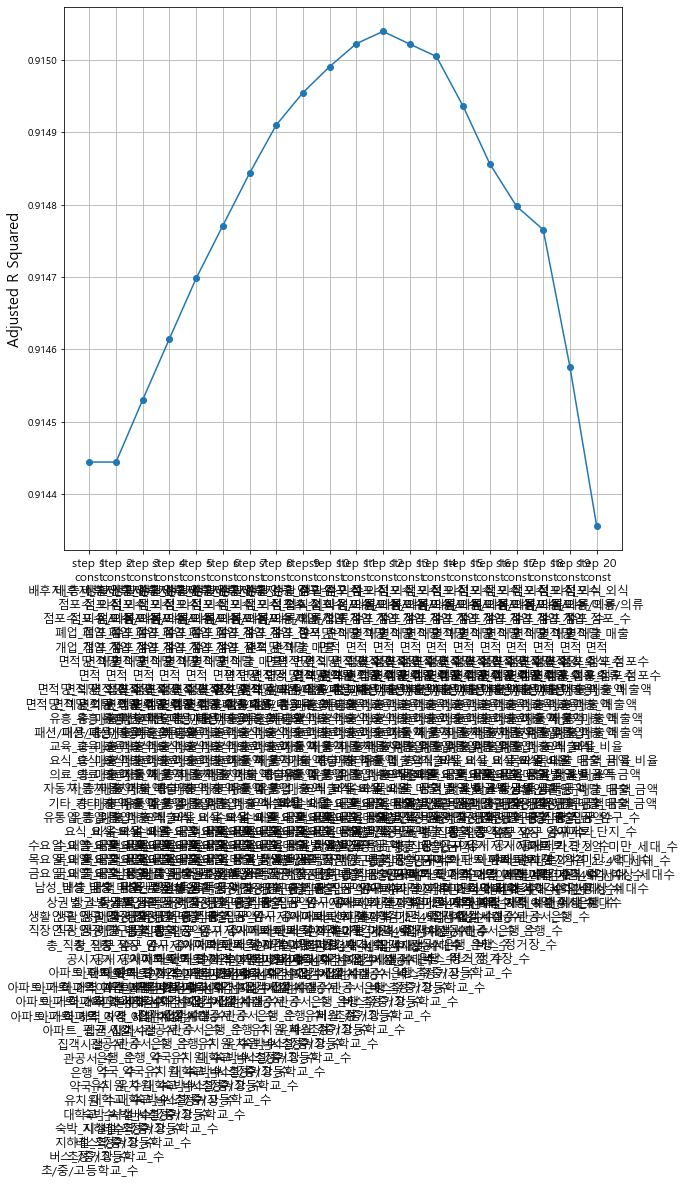

In [75]:
b_R_mdoel = backward_R_sq(df_X, df_y)

## 유효한 피쳐 선택

step_AIC_model
b_AIC_model
f_AIC_model

s_R_model
b_R_mdoel
f_R_model

In [77]:
s_AIC_model.sort_values('AIC').head(1)['SUMMARY'][27]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     426.0
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:02:41   Log-Likelihood:                -23616.
No. Observations:                 989   AIC:                         4.728e+04
Df Residuals:                     963   BIC:                         4.741e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
면적당_매출                0.4788      0.013     36.098      0.000       0.453       0.505
면적                -2.614e+09   9.38e+08     -2.786      0.005   -4.46e+09   -7.73e+08
면적당_외식_점포수        -2.191e+08   1.34e+07    -16.344      0.000   -2.45e+08   -1.93e+08
점포수_외식             3.294e+08   2.12e+07     15.504      0.000    2.88e+08    3.71e+08
교육_총_매출액              1.3824      0.182      7.615      0.000       1.026       1.739
패션/미용_총_매출액           0.7250      0.156      4.640      0.000       0.418       1.032
직장인구_당_매출_금액        869.1297    141.258      6.153      0.000     591.920    1146.339
총_직장_인구_수          2.371e+04   7299.794      3.248      0.001    9382.963     3.8e+04
은행_수               1.379e+09   3.66e+08      3.766      0.000     6.6e+08     2.1e+09
생활인구_당_매출_금액       9.012e+05   1.85e+05      4.881      0.000    5.39e+05    1.26e+06
아파트_단지_수           1.758e+06   5.89e+05      2.986      0.003    6.03e+05    2.91e+06
점포수_미용/의류          2.356e+08   2.76e+07      8.535      0.000    1.81e+08     2.9e+08
면적당_미용의류_점포수      -1.424e+08   1.67e+07     -8.519      0.000   -1.75e+08    -1.1e+08
아파트_가격_2억_미만_세대_수 -1.545e+05   7.12e+04     -2.170      0.030   -2.94e+05   -1.48e+04
지리_다양성_지수         -1.794e+09   7.04e+08     -2.547      0.011   -3.18e+09   -4.12e+08
자동차_총_매출액             0.4343      0.131      3.319      0.001       0.178       0.691
요식_비율              5.753e+09   1.62e+09      3.547      0.000    2.57e+09    8.94e+09
유통업_총_매출액             0.2463      0.107      2.302      0.022       0.036       0.456
아파트_가격_2~4억_세대_수   1.606e+05   5.06e+04      3.176      0.002    6.14e+04     2.6e+05
목요일_매출_금액_비율         3.1e+10   1.37e+10      2.259      0.024    4.06e+09    5.79e+10
개업_점포_수            2.791e+08    1.2e+08      2.318      0.021    4.28e+07    5.15e+08
상권별_소득금액           -117.5568     34.608     -3.397      0.001    -185.473     -49.641
아파트_가격_5억_이상_세대수   2.336e+05   9.13e+04      2.560      0.011    5.45e+04    4.13e+05
의료_총_매출액              0.1039      0.055      1.889      0.059      -0.004       0.212
공시지가                223.0434    119.468      1.867      0.062     -11.404     457.491
const              1.199e+09   2.01e+09      0.598      0.550   -2.74e+09    5.13e+09
==============================================================================
Omnibus:                      619.902   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            87553.469
Skew:                          -1.869   Prob(JB):                         0.00
Kurtosis:                      48.942   Cond. No.                     3.28e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The conditi

In [83]:
s_R_model.sort_values('R_square',ascending=False).head(1)['SUMMARY'][23]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     727.6
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:02:56   Log-Likelihood:                -23642.
No. Observations:                 989   AIC:                         4.731e+04
Df Residuals:                     974   BIC:                         4.739e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
면적당_매출           0.5004      0.012     40.143      0.000       0.476       0.525
면적당_외식_점포수    -2.19e+08   1.25e+07    -17.525      0.000   -2.44e+08   -1.95e+08
점포수_외식        3.453e+08   2.04e+07     16.940      0.000    3.05e+08    3.85e+08
교육_총_매출액         1.2954      0.175      7.382      0.000       0.951       1.640
패션/미용_총_매출액      0.6582      0.156      4.223      0.000       0.352       0.964
직장인구_당_매출_금액   773.5019    140.372      5.510      0.000     498.036    1048.968
총_직장_인구_수     2.586e+04   6505.642      3.976      0.000    1.31e+04    3.86e+04
은행_수          1.141e+09   3.57e+08      3.201      0.001    4.42e+08    1.84e+09
생활인구_당_매출_금액  5.739e+05   1.63e+05      3.531      0.000    2.55e+05    8.93e+05
점포수_미용/의류     2.378e+08   2.73e+07      8.704      0.000    1.84e+08    2.91e+08
면적당_미용의류_점포수 -1.385e+08   1.65e+07     -8.403      0.000   -1.71e+08   -1.06e+08
관공서_수        -6.544e+08   2.62e+08     -2.498      0.013   -1.17e+09    -1.4e+08
개업_점포_수       2.794e+08   1.18e+08      2.360      0.018    4.71e+07    5.12e+08
목요일_매출_금액_비율   2.86e+10   1.38e+10      2.079      0.038     1.6e+09    5.56e+10
const        -2.915e+09   1.15e+09     -2.527      0.012   -5.18e+09   -6.51e+08
아파트_평균_시가     -335.3481    159.111     -2.108      0.035    -647.589     -23.108
==============================================================================
Omnibus:                      669.374   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107456.417
Skew:                          -2.101   Prob(JB):                         0.00
Kurtosis:                      53.892   Cond. No.                     2.61e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.76e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 최종 feature 선택

In [86]:
AIC_feature_list = s_AIC_model.sort_values('AIC').head(1)['Features'][27]

In [87]:
R_feature_list = s_R_model.sort_values('R_square',ascending=False).head(1)['Features'][23]

In [88]:
최종_feature = list(set(AIC_feature_list + R_feature_list))

In [89]:
최종_feature

['교육_총_매출액',
 '의료_총_매출액',
 '점포수_외식',
 '목요일_매출_금액_비율',
 '아파트_가격_2~4억_세대_수',
 '지리_다양성_지수',
 '총_직장_인구_수',
 '면적당_미용의류_점포수',
 '점포수_미용/의류',
 '공시지가',
 '면적',
 '생활인구_당_매출_금액',
 '직장인구_당_매출_금액',
 '패션/미용_총_매출액',
 '아파트_가격_5억_이상_세대수',
 '개업_점포_수',
 '아파트_단지_수',
 '자동차_총_매출액',
 '상권별_소득금액',
 '면적당_외식_점포수',
 '아파트_평균_시가',
 '유통업_총_매출액',
 '면적당_매출',
 'const',
 '관공서_수',
 '요식_비율',
 '은행_수',
 '아파트_가격_2억_미만_세대_수']

In [90]:
import pickle
 
## Save pickle
with open("data/indicator/매출기반_feature.pickle","wb") as fw:
    pickle.dump(최종_feature, fw)
 